In [58]:
import pandas as pd
import os
import glob
from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings
import matplotlib.pyplot as plt
from IPython.display import HTML, display, Markdown
from copy import copy
import seaborn as sns
import numpy as np

from utils.conn_data import load_pickle

In [59]:
outputs_path = os.path.join(os.path.dirname(os.getcwd()), "src", "data", "outputs")
results_path = os.path.join(os.path.dirname(os.getcwd()), "src", "data", "outputs", "results")

# des = pd.read_csv(os.path.join(os.getcwd(), 'data', 'utils', 'fredmd_description.csv'), sep=';')

fs_methods_tags = {}
# fs_methods_tags = {
#     "lasso1_nocluster": "Lasso",
#     "pairwise-granger_nocluster": "Pairwise Granger",
#     "multivariate-granger_nocluster": "Multivariate Granger",
#     "dynotears_rollingcluster_k5": "Dynotears",
#     "var-lingam_rollingcluster_k5": "VAR-LiNGAM",

# }

fs_methods = [
    # "seqICP_nocluster",
    "pcmci_nocluster",
    "dynotears_nocluster", 
    "pairwise-granger_nocluster",
    "var-lingam_nocluster",
    "sfstscv-rf_nocluster"
    ]

etfs = [
    "SPY"
]

# event_dates = [
#     ("GFC", ("2007-07-01", "2008-11-01")),
#     ("Dow Jones Flash Crash", ("2010-03-01", "2010-07-01")),
#     ("Tsunami Fukushima", ("2011-01-01", "2011-05-01")),
#     ("Black Monday 2011", ("2011-06-01", "2011-10-01")),
#     ("Chinese Black Monday", ("2015-06-01", "2015-10-01")),
#     ("Dow Jones Plunge 2018", ("2018-01-01", "2018-05-01")),
#     ("COVID-19", ("2020-01-01", "2020-05-01"))
# ]

event_dates = [
    ("GFC", ("2008-09-01", "2008-11-01")),
    ("Eurozone Debt Crisis", ("2010-05-01", "2012-07-01")),
    ("Swiss Franc Peg Announcement", ("2011-07-01", "2011-09-01")),
    ("Swiss Franc Peg Removal", ("2014-12-01", "2015-02-01")),
    ("COVID-19", ("2020-01-01", "2020-04-01"))
]

metric_names = ["mse", "mae", "rmse"]
etf_focus = None
stability_threshold = 0.8   
plot_ts = False

In [60]:
warnings.simplefilter("ignore")

all_metrics = []
all_rolling_metrics = []
all_stability = []
all_parents = []
for fs in fs_methods:
    print(fs)

    if plot_ts:
        display(Markdown(f"## {fs}"))

    # list results files with glob
    results_files = glob.glob(os.path.join(outputs_path, fs, "monetary-policy-processed", "*.pickle"))

    if len(results_files) == 0:
        raise Exception(f"No results files found for {fs}")

    # load results files
    stability = []
    metrics = []
    for file in results_files:
        etf = file.split(fs)[-1].split("/")[-1].split("_")[0]

        # if etf not in etfs:
        #     continue
        # else:
        #     pass

        obj = load_pickle(path=file)

        # plot predictions
        predictions_df = obj['predictions'].loc["2006-01-01":]

        # filter predictions
        predictions_df.loc[(predictions_df['prediction_zscore'] == 1)|(predictions_df['prediction_zscore'] == -1), 'prediction_zscore'] = 0
        predictions_df.loc[(predictions_df['prediction'] == 1)|(predictions_df['prediction'] == -1), 'prediction'] = 0
        
        # Dictionary to hold the data subsets for each event
        crisis_predictions = []

        # Loop through the event_dates list, subset the DataFrame, and store each subset in the dictionary
        for event_name, (start_date, end_date) in event_dates:
            # Subset the DataFrame within the specified date range
            subset_df = predictions_df.loc[start_date:end_date]
            # Store the subset DataFrame in the dictionary with the event name as the key
            crisis_predictions.append(subset_df)

        if plot_ts:
            fig, ax = plt.subplots(figsize=(10, 5))
            ax.set_title(label=f'OOS Predictions for {etf}', fontsize=15)
            ax.plot(pd.to_datetime(predictions_df.index), predictions_df["prediction"], label="predictions")
            ax.plot(pd.to_datetime(predictions_df.index), predictions_df["true"], label="true")
            plt.xlabel("Date")
            plt.ylabel("Returns")
            plt.legend(loc='best', fontsize=10)   
            plt.show()

        # compute rolling mse
        rolling_metric_df = predictions_df.copy()
        rolling_metric_df["diff"] = rolling_metric_df["true"] - rolling_metric_df["prediction"]

        # rolling mse
        rolling_metric_df["rolling_var"] = rolling_metric_df["prediction"].rolling(12).var()
        rolling_metric_df["rolling_bias"] = (rolling_metric_df["true"] - rolling_metric_df["prediction"]).pow(2).rolling(12).mean()
        rolling_metric_df["rolling_mse"] = ((rolling_metric_df["true"]  - rolling_metric_df["prediction"]) ** 2).rolling(window=12).mean()
        rolling_metric_df["rolling_mae"] = (abs(rolling_metric_df["true"] - rolling_metric_df["prediction"])).rolling(window=12).mean()
        rolling_metric_df["rolling_rmse"] = np.sqrt(((rolling_metric_df["true"] - rolling_metric_df["prediction"]) ** 2).rolling(window=12).mean())
        rolling_metric_df["rolling_var"] = (rolling_metric_df["rolling_var"] / rolling_metric_df["rolling_mse"]) * 100
        rolling_metric_df["rolling_bias"] = (rolling_metric_df["rolling_bias"] / rolling_metric_df["rolling_mse"]) * 100
        rolling_metric_df = rolling_metric_df[["diff", "rolling_mse", "rolling_mae", "rolling_rmse", "rolling_var", "rolling_bias"]]

        # add info
        rolling_metric_df["fs"] = fs_methods_tags[fs] if len(fs_methods_tags) > 0 else fs
        rolling_metric_df["etf"] = etf

        # melt
        melt_rolling_metric_df = rolling_metric_df.reset_index().melt(["date", "fs", "etf"])

        # compute forecast metrics
        mse = mean_squared_error(predictions_df["true"], predictions_df["prediction"]) * 100
        mae = mean_absolute_error(predictions_df["true"], predictions_df["prediction"]) * 100
        rmse = np.sqrt(mean_squared_error(predictions_df["true"], predictions_df["prediction"])) * 100

        crisis_predictions_df = pd.concat(crisis_predictions)
        crisis_mse = mean_squared_error(crisis_predictions_df["true"], crisis_predictions_df["prediction"]) * 100
        crisis_mae = mean_absolute_error(crisis_predictions_df["true"], crisis_predictions_df["prediction"]) * 100
        crisis_rmse = np.sqrt(mean_squared_error(crisis_predictions_df["true"], crisis_predictions_df["prediction"])) * 100

        # compute cluster stability metrics
        parents_of_target_df = obj["parents_of_target"]

        # add tags
        parents_of_target_df["etf"] = etf
        parents_of_target_df["fs"] = fs

        # fill na of clusters column
        if "nocluster" in fs:
            parents_of_target_df['cluster'] = pd.factorize(parents_of_target_df['fred'])[0]
        elif ("pca" in fs):
            codes, uniques = pd.factorize(parents_of_target_df['fred'])
            parents_of_target_df['cluster'] = codes         
        else:
            parents_of_target_df["cluster"] = parents_of_target_df["cluster"].fillna(parents_of_target_df["cluster"].max() + 1)

        all_parents.append(parents_of_target_df)

        metrics_df = pd.DataFrame({
            "fs": fs_methods_tags[fs] if len(fs_methods_tags) > 0 else fs, 
            "etf": etf, 
            "mse": [mse],
            "mae": [mae], 
            "rmse": [rmse],
            "mse_crisis": [crisis_mse], 
            "mae_crisis": [crisis_mae],
            "rmse_crisis": [crisis_rmse]})
        metrics.append(metrics_df)
        all_rolling_metrics.append(melt_rolling_metric_df)
    
    all_metrics.append(pd.concat(metrics).set_index(["fs", "etf"]))
all_metrics_df = pd.concat(all_metrics)
all_rolling_metrics_df = pd.concat(all_rolling_metrics)
all_parents_df = pd.concat(all_parents)
melted_all_metrics_df = all_metrics_df.reset_index().melt(id_vars=["fs", "etf"])

pcmci_nocluster
dynotears_nocluster
pairwise-granger_nocluster
var-lingam_nocluster
sfstscv-rf_nocluster


## Debugging

In [61]:
# fs = "seqICP_nocluster"

# # list results files with glob
# results_files = glob.glob(os.path.join(outputs_path, fs, "monetary-policy-processed", "*.pickle"))

# file = next(iter(results_files))
# etf = file.split(fs)[-1].split("/")[-1].split("_")[0]

# print(f"{file}")

# obj = load_pickle(path=file)

# # compute cluster stability metrics
# parents_of_target_df = obj["parents_of_target"]

# # # add tags
# # parents_of_target_df["etf"] = etf
# # parents_of_target_df["fs"] = fs

# # # fill na of clusters column
# # if "nocluster" in fs:
# #     parents_of_target_df['cluster'] = pd.factorize(parents_of_target_df['fred'])[0]
# # elif ("pca" in fs):
# #     codes, uniques = pd.factorize(parents_of_target_df['fred'])
# #     parents_of_target_df['cluster'] = codes         
# # else:
# #     parents_of_target_df["cluster"] = parents_of_target_df["cluster"].fillna(parents_of_target_df["cluster"].max() + 1)

# # all_parents.append(parents_of_target_df)

In [62]:
# parents_of_target_df

## Table with summary statistics

In [63]:
melted_all_metrics_df["crisis"] = [val.split("_")[-1] if len(val.split("_")) > 1 else "nocrisis" for val in melted_all_metrics_df["variable"] ]
melted_all_metrics_df["variable"] = [val.split("_")[0] for val in melted_all_metrics_df["variable"] ]

In [64]:
pivot_df = melted_all_metrics_df.pivot_table(
    index=['fs'], 
    columns=['variable', 'crisis'], 
    values='value',
    aggfunc='mean'
)

pivot_df = pivot_df.reindex(columns=['nocrisis', 'crisis'], level='crisis')

pivot_df

variable                          mae                     mse              \
crisis                       nocrisis      crisis    nocrisis      crisis   
fs                                                                          
dynotears_nocluster         72.060347  160.829923  163.025431  564.456091   
pairwise-granger_nocluster  80.046784  176.319043  185.322946  622.016660   
pcmci_nocluster             72.057389  154.316635  151.470323  495.791263   
sfstscv-rf_nocluster        92.545608  195.220483  244.673272  791.913017   
var-lingam_nocluster        73.471838  163.806505  159.555995  537.135608   

variable                          rmse              
crisis                        nocrisis      crisis  
fs                                                  
dynotears_nocluster         127.681413  237.582847  
pairwise-granger_nocluster  136.133371  249.402618  
pcmci_nocluster             123.073280  222.663707  
sfstscv-rf_nocluster        156.420354  281.409491  
var-lingam_nocluster        126.315476  231.761862

In [65]:
# Define a function to compute the differences
def compute_differences(row):
    new_row = {}
    for variable in ['mae', 'mse', 'rmse']:  # Add other variables if necessary
        new_row[(variable, 'Generalization Gap')] = row[(variable, 'nocrisis')] - row[(variable, 'crisis')]
    return pd.Series(new_row)

# Apply the function across the dataframe and create a new dataframe with the results
diff_df = pivot_df.apply(compute_differences, axis=1)

# To simplify the view, you might want to sort or organize the columns
diff_df = diff_df.sort_index(axis=1)

diff_df

,mae,mse,rmse
,Generalization Gap,Generalization Gap,Generalization Gap
fs,,,
dynotears_nocluster,-88.769577,-401.430660,-109.901434
pairwise-granger_nocluster,-96.272259,-436.693714,-113.269248
pcmci_nocluster,-82.259246,-344.320940,-99.590427
sfstscv-rf_nocluster,-102.674874,-547.239746,-124.989137
var-lingam_nocluster,-90.334667,-377.579613,-105.446386


## Boxplots with summary statistics

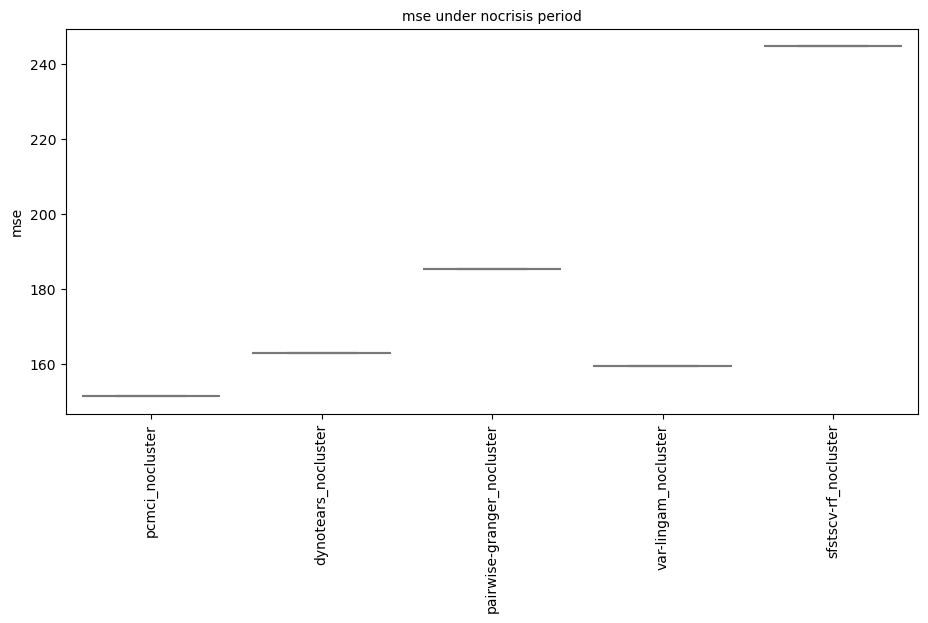

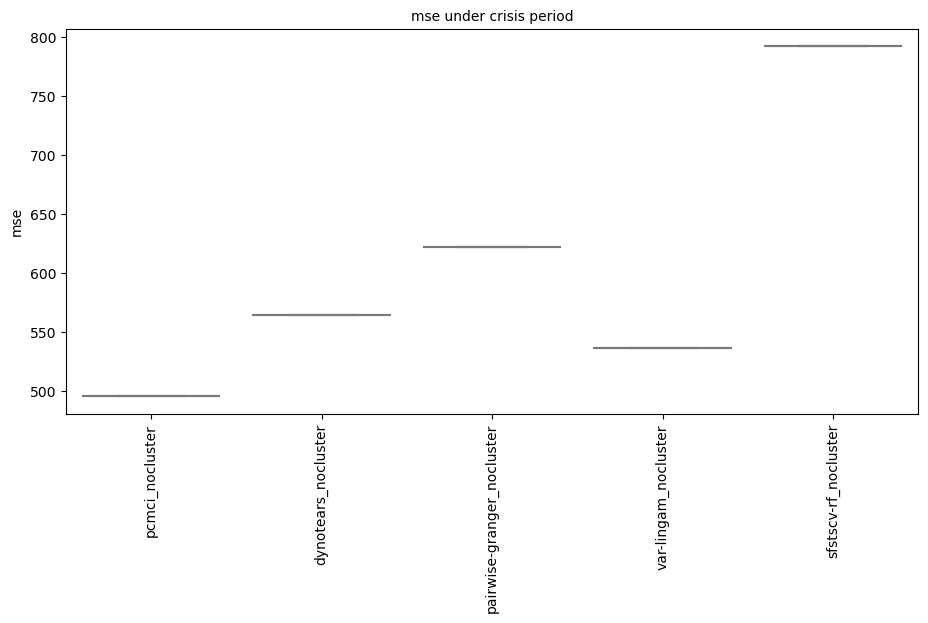

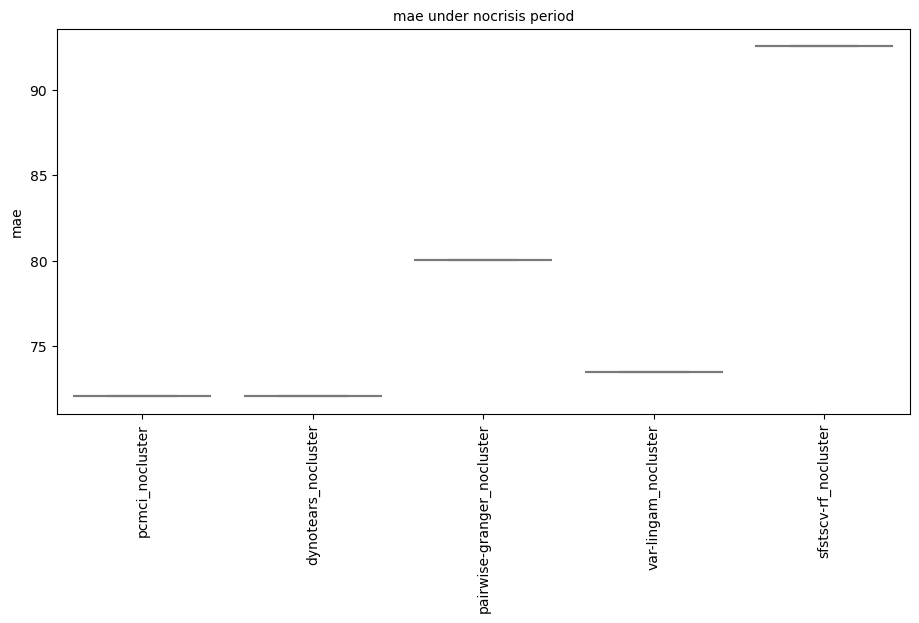

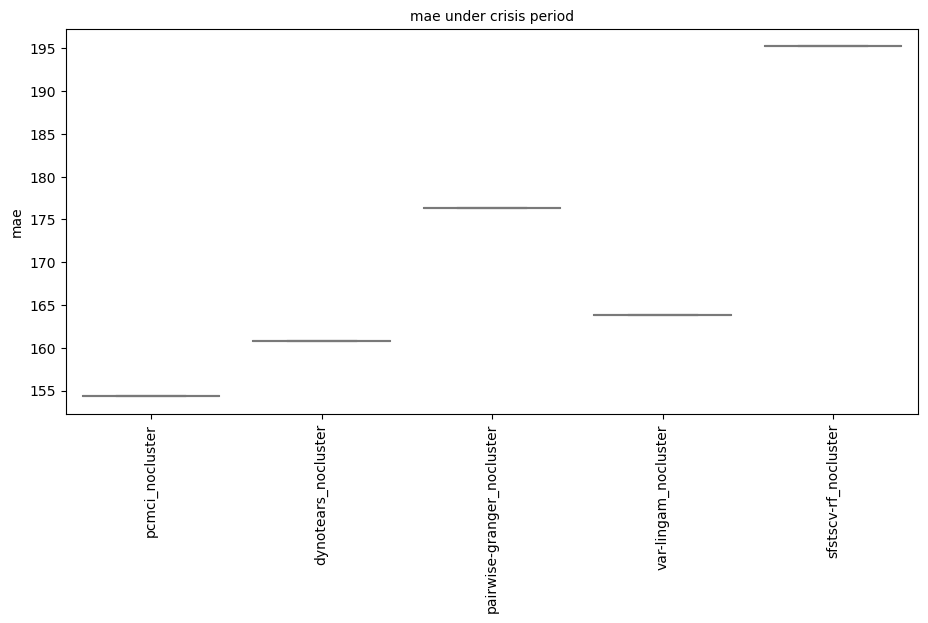

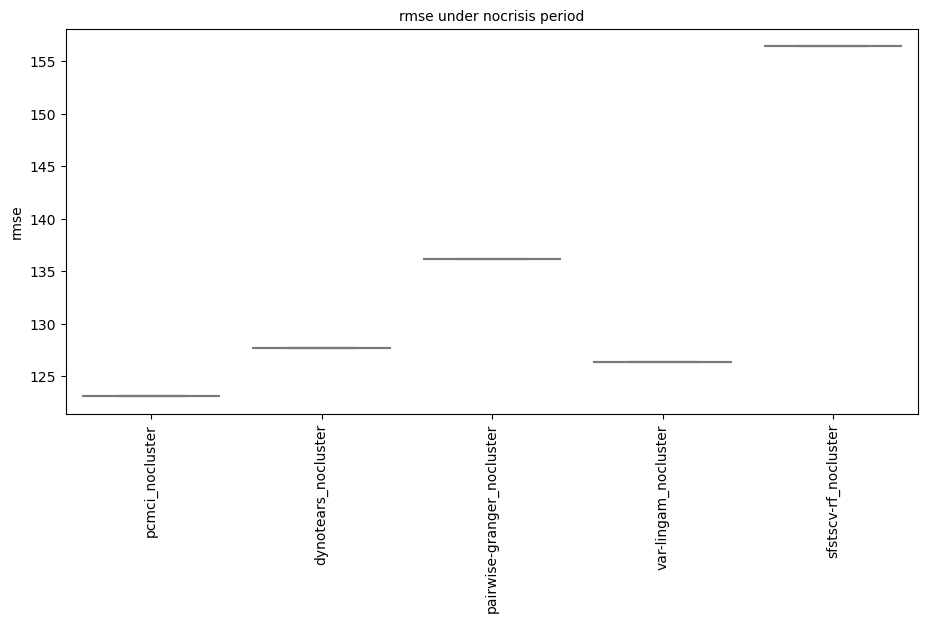

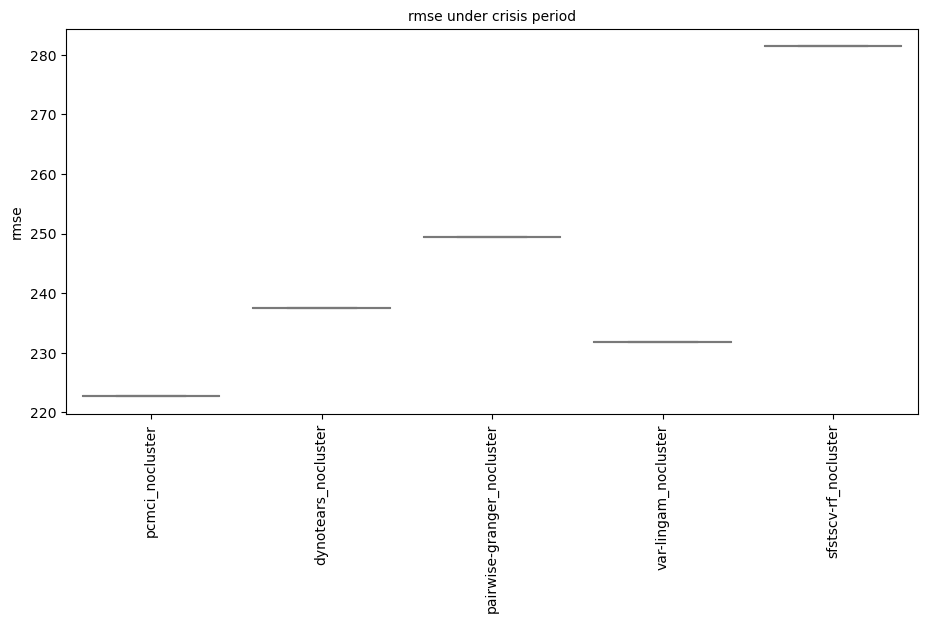

In [66]:
for m in metric_names:
    for c in melted_all_metrics_df["crisis"].unique():
        boxplot_df = melted_all_metrics_df.loc[(melted_all_metrics_df["variable"] == m)&
                                               (melted_all_metrics_df["crisis"] == c)].drop(["variable"], axis=1)

        fig, ax = plt.subplots(figsize=(11, 5))
        sns.boxplot(x="fs", y='value',data=boxplot_df, ax=ax, color='lightblue')
        ax.set_title(f"{m} under {c} period", fontsize=10)
        ax.set_ylabel(m, fontsize=10)
        ax.set_xlabel("", fontsize=10)
        ax.tick_params(axis="x", labelsize=10)
        ax.tick_params(axis="y", labelsize=10)
        # ax.legend(loc="best",fontsize=10)
        plt.xticks(rotation=90)
        fig.savefig(os.path.join(results_path, f'boxplot_agg_{m}_{c}_fs.png'))

## Prediction error over time

### (a) Rolling MSE

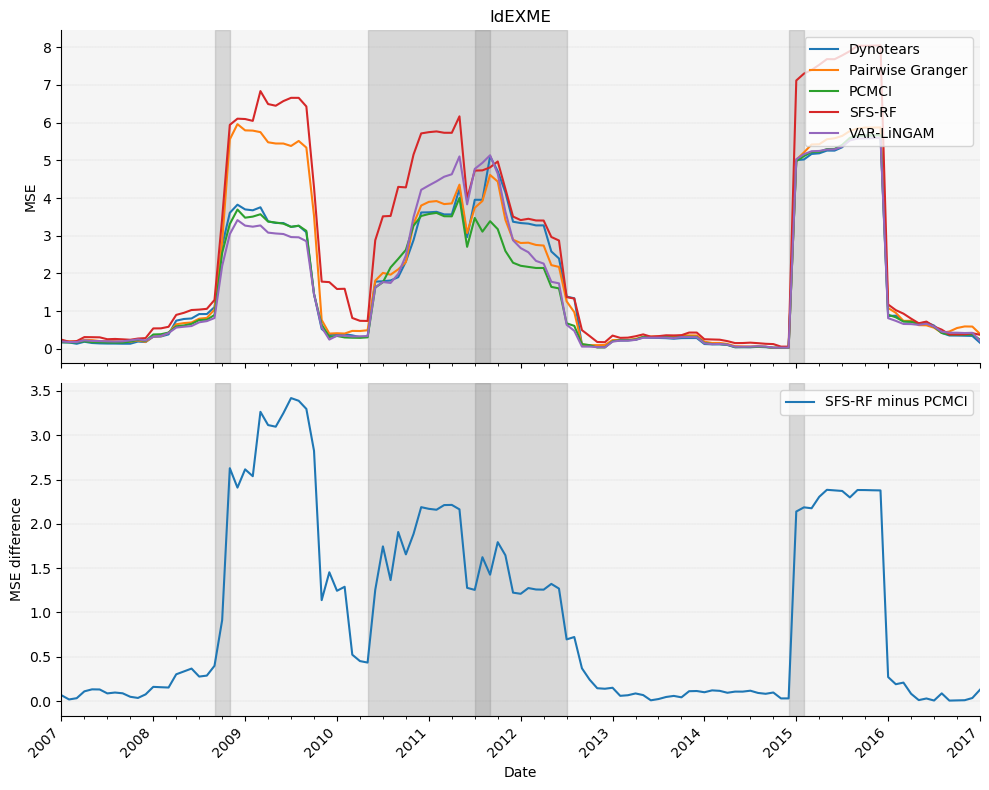

In [67]:
# SPY, XLP, XLK, XLY, XLF, XLB, XLI 

benchmark_name = "sfstscv-rf_nocluster"
causal_name = "pcmci_nocluster"

selected_models = fs_methods.copy()

rename_fs = {
    "sfstscv-rf_nocluster": "SFS-RF",
    "dynotears_nocluster": "Dynotears",
    "pairwise-granger_nocluster": "Pairwise Granger",
    "seqICP_nocluster": "seqICP",
    # "multivariate-granger_nocluster": "Multivariate Granger",
    # "var-lingam_rollingkmeans_k5_rank": "Modified VAR-LiNGAM",
    "var-lingam_nocluster": "VAR-LiNGAM",
    "pcmci_nocluster": "PCMCI"
}

column_name = f"{rename_fs[benchmark_name]} minus {rename_fs[causal_name]}"

for etf in all_rolling_metrics_df["etf"].unique():
    etf_rolling_metrics_df = all_rolling_metrics_df.loc[(all_rolling_metrics_df["etf"] == etf)&(all_rolling_metrics_df["variable"]=="rolling_mse")].pivot_table(index=["date"], columns=["fs"], values=["value"])
    # etf_rolling_metrics_df = all_rolling_metrics_df.loc[(all_rolling_metrics_df["etf"] == etf)&(all_rolling_metrics_df["variable"]=="rolling_mse")&(all_rolling_metrics_df["fs"].isin(selected_models))].pivot_table(index=["date"], columns=["fs"], values=["value"])
    etf_rolling_metrics_df.columns = etf_rolling_metrics_df.columns.droplevel()
    etf_rolling_metrics_df[column_name] = etf_rolling_metrics_df[benchmark_name] - etf_rolling_metrics_df[causal_name]
    etf_rolling_metrics_df = etf_rolling_metrics_df.rename(columns=rename_fs)

     # Plotting
    fig, axs = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

    # Plotting on the upper subplot
    etf_rolling_metrics_df.drop([column_name], axis=1).plot(ax=axs[0])
    axs[0].set_title(f'{etf}')
    axs[0].set_ylabel('MSE')
    axs[0].legend(loc='upper right')
    axs[0].grid(True, axis='y', which='major', linestyle='--', linewidth='0.1', color='gray')
    axs[0].set_facecolor('whitesmoke')
    axs[0].spines['top'].set_visible(False)
    axs[0].spines['right'].set_visible(False)

    # Plotting on the lower subplot
    etf_rolling_metrics_df[column_name].plot(ax=axs[1])
    axs[1].set_xlabel('Date')
    axs[1].set_ylabel('MSE difference')
    axs[1].legend(loc='upper right')
    axs[1].grid(True, axis='y', which='major', linestyle='--', linewidth='0.1', color='gray')
    axs[1].set_facecolor('whitesmoke')
    axs[1].spines['top'].set_visible(False)
    axs[1].spines['right'].set_visible(False)

    # Add shaded regions for each event
    for event_name, date in event_dates:
        start_date, end_date = date[0], date[1]
        axs[0].axvspan(pd.to_datetime(start_date), pd.to_datetime(end_date), color='grey', alpha=0.25)
        axs[1].axvspan(pd.to_datetime(start_date), pd.to_datetime(end_date), color='grey', alpha=0.25)

        #  # Check if the event is GFC and add text label
        # if (event_name == "GFC") or (event_name == "COVID-19"):
        #     mid_point = pd.to_datetime(start_date) + (pd.to_datetime(end_date) - pd.to_datetime(start_date)) / 2
        #     axs[0].text(mid_point, axs[0].get_ylim()[1] * 0.55, event_name, horizontalalignment='center', verticalalignment='top', color='black', fontsize=10)
        #     axs[1].text(mid_point, axs[1].get_ylim()[1] * 0.55, event_name, horizontalalignment='center', verticalalignment='top', color='black', fontsize=10)


    # Set x-ticks to yearly frequency, adjust as necessary
    tick_positions = pd.date_range(start=etf_rolling_metrics_df.index.min(), end=etf_rolling_metrics_df.index.max(), freq='AS')
    axs[1].set_xticks(tick_positions)
    axs[1].set_xticklabels([tp.strftime('%Y') for tp in tick_positions], rotation=45, ha='right')

    # Adjust layout for better visualization
    plt.tight_layout()

    # Export plot
    fig.savefig(os.path.join(results_path, f'{etf}_rolling_mse.png'))

    # Show the plot
    plt.show()

### (b) Rolling RMSE

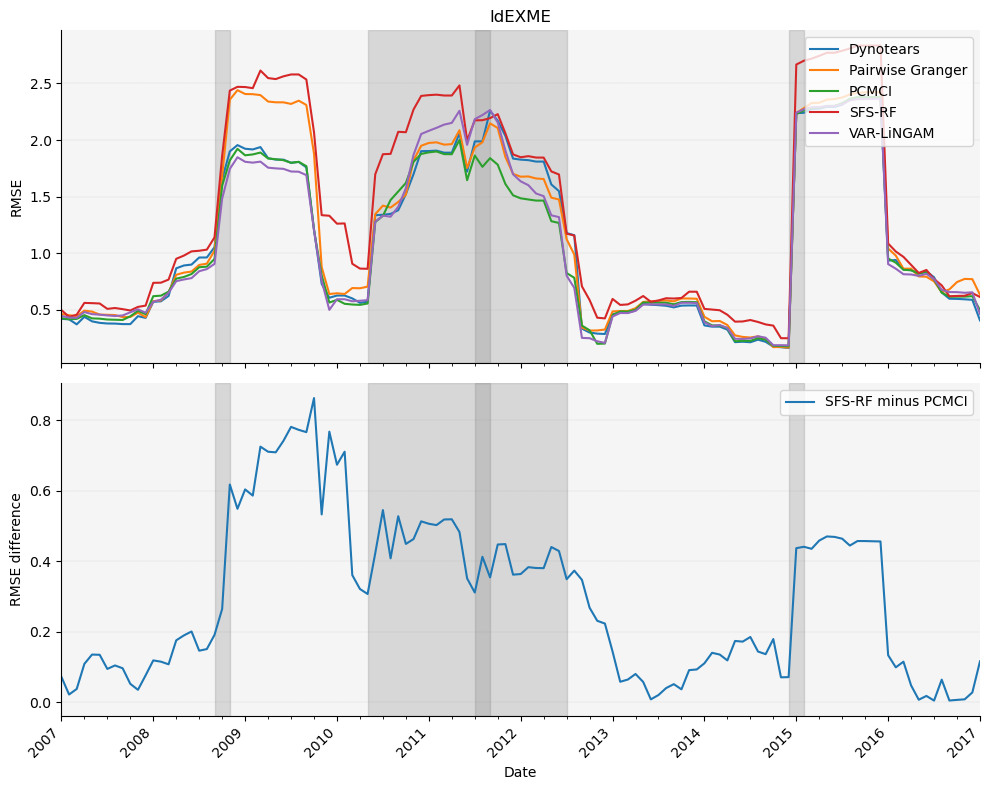

In [68]:
# SPY, XLP, XLK, XLY, XLF, XLB, XLI 

benchmark_name = "sfstscv-rf_nocluster"
causal_name = "pcmci_nocluster"

selected_models = fs_methods.copy()

rename_fs = {
    "sfstscv-rf_nocluster": "SFS-RF",
    "dynotears_nocluster": "Dynotears",
    "pairwise-granger_nocluster": "Pairwise Granger",
    "seqICP_nocluster": "seqICP",
    # "multivariate-granger_nocluster": "Multivariate Granger",
    # "var-lingam_rollingkmeans_k5_rank": "Modified VAR-LiNGAM",
    "var-lingam_nocluster": "VAR-LiNGAM",
    "pcmci_nocluster": "PCMCI"
}

column_name = f"{rename_fs[benchmark_name]} minus {rename_fs[causal_name]}"

for etf in all_rolling_metrics_df["etf"].unique():
    etf_rolling_metrics_df = all_rolling_metrics_df.loc[(all_rolling_metrics_df["etf"] == etf)&(all_rolling_metrics_df["variable"]=="rolling_rmse")].pivot_table(index=["date"], columns=["fs"], values=["value"])
    # etf_rolling_metrics_df = all_rolling_metrics_df.loc[(all_rolling_metrics_df["etf"] == etf)&(all_rolling_metrics_df["variable"]=="rolling_mse")&(all_rolling_metrics_df["fs"].isin(selected_models))].pivot_table(index=["date"], columns=["fs"], values=["value"])
    etf_rolling_metrics_df.columns = etf_rolling_metrics_df.columns.droplevel()
    etf_rolling_metrics_df[column_name] = etf_rolling_metrics_df[benchmark_name] - etf_rolling_metrics_df[causal_name]
    etf_rolling_metrics_df = etf_rolling_metrics_df.rename(columns=rename_fs)

     # Plotting
    fig, axs = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

    # Plotting on the upper subplot
    etf_rolling_metrics_df.drop([column_name], axis=1).plot(ax=axs[0])
    axs[0].set_title(f'{etf}')
    axs[0].set_ylabel('RMSE')
    axs[0].legend(loc='upper right')
    axs[0].grid(True, axis='y', which='major', linestyle='--', linewidth='0.1', color='gray')
    axs[0].set_facecolor('whitesmoke')
    axs[0].spines['top'].set_visible(False)
    axs[0].spines['right'].set_visible(False)

    # Plotting on the lower subplot
    etf_rolling_metrics_df[column_name].plot(ax=axs[1])
    axs[1].set_xlabel('Date')
    axs[1].set_ylabel('RMSE difference')
    axs[1].legend(loc='upper right')
    axs[1].grid(True, axis='y', which='major', linestyle='--', linewidth='0.1', color='gray')
    axs[1].set_facecolor('whitesmoke')
    axs[1].spines['top'].set_visible(False)
    axs[1].spines['right'].set_visible(False)

    # Add shaded regions for each event
    for event_name, date in event_dates:
        start_date, end_date = date[0], date[1]
        axs[0].axvspan(pd.to_datetime(start_date), pd.to_datetime(end_date), color='grey', alpha=0.25)
        axs[1].axvspan(pd.to_datetime(start_date), pd.to_datetime(end_date), color='grey', alpha=0.25)

        #  # Check if the event is GFC and add text label
        # if (event_name == "GFC") or (event_name == "COVID-19"):
        #     mid_point = pd.to_datetime(start_date) + (pd.to_datetime(end_date) - pd.to_datetime(start_date)) / 2
        #     axs[0].text(mid_point, axs[0].get_ylim()[1] * 0.55, event_name, horizontalalignment='center', verticalalignment='top', color='black', fontsize=10)
        #     axs[1].text(mid_point, axs[1].get_ylim()[1] * 0.55, event_name, horizontalalignment='center', verticalalignment='top', color='black', fontsize=10)


    # Set x-ticks to yearly frequency, adjust as necessary
    tick_positions = pd.date_range(start=etf_rolling_metrics_df.index.min(), end=etf_rolling_metrics_df.index.max(), freq='AS')
    axs[1].set_xticks(tick_positions)
    axs[1].set_xticklabels([tp.strftime('%Y') for tp in tick_positions], rotation=45, ha='right')

    # Adjust layout for better visualization
    plt.tight_layout()

    # Export plot
    fig.savefig(os.path.join(results_path, f'{etf}_rolling_rmse.png'))

    # Show the plot
    plt.show()

### (c) Rolling MAE

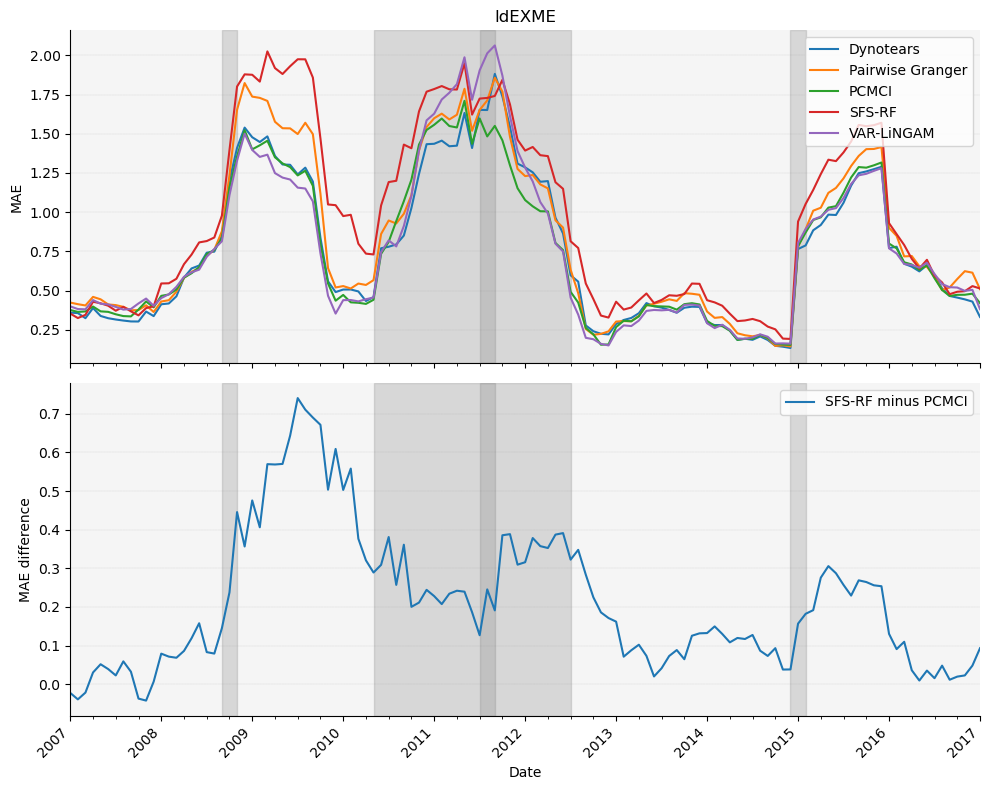

In [69]:
# SPY, XLP, XLK, XLY, XLF, XLB, XLI 

benchmark_name = "sfstscv-rf_nocluster"
causal_name = "pcmci_nocluster"

selected_models = fs_methods.copy()

rename_fs = {
    "sfstscv-rf_nocluster": "SFS-RF",
    "dynotears_nocluster": "Dynotears",
    "pairwise-granger_nocluster": "Pairwise Granger",
    "seqICP_nocluster": "seqICP",
    # "multivariate-granger_nocluster": "Multivariate Granger",
    # "var-lingam_rollingkmeans_k5_rank": "Modified VAR-LiNGAM",
    "var-lingam_nocluster": "VAR-LiNGAM",
    "pcmci_nocluster": "PCMCI"
}

column_name = f"{rename_fs[benchmark_name]} minus {rename_fs[causal_name]}"

for etf in all_rolling_metrics_df["etf"].unique():
    etf_rolling_metrics_df = all_rolling_metrics_df.loc[(all_rolling_metrics_df["etf"] == etf)&(all_rolling_metrics_df["variable"]=="rolling_mae")].pivot_table(index=["date"], columns=["fs"], values=["value"])
    # etf_rolling_metrics_df = all_rolling_metrics_df.loc[(all_rolling_metrics_df["etf"] == etf)&(all_rolling_metrics_df["variable"]=="rolling_mse")&(all_rolling_metrics_df["fs"].isin(selected_models))].pivot_table(index=["date"], columns=["fs"], values=["value"])
    etf_rolling_metrics_df.columns = etf_rolling_metrics_df.columns.droplevel()
    etf_rolling_metrics_df[column_name] = etf_rolling_metrics_df[benchmark_name] - etf_rolling_metrics_df[causal_name]
    etf_rolling_metrics_df = etf_rolling_metrics_df.rename(columns=rename_fs)

     # Plotting
    fig, axs = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

    # Plotting on the upper subplot
    etf_rolling_metrics_df.drop([column_name], axis=1).plot(ax=axs[0])
    axs[0].set_title(f'{etf}')
    axs[0].set_ylabel('MAE')
    axs[0].legend(loc='upper right')
    axs[0].grid(True, axis='y', which='major', linestyle='--', linewidth='0.1', color='gray')
    axs[0].set_facecolor('whitesmoke')
    axs[0].spines['top'].set_visible(False)
    axs[0].spines['right'].set_visible(False)

    # Plotting on the lower subplot
    etf_rolling_metrics_df[column_name].plot(ax=axs[1])
    axs[1].set_xlabel('Date')
    axs[1].set_ylabel('MAE difference')
    axs[1].legend(loc='upper right')
    axs[1].grid(True, axis='y', which='major', linestyle='--', linewidth='0.1', color='gray')
    axs[1].set_facecolor('whitesmoke')
    axs[1].spines['top'].set_visible(False)
    axs[1].spines['right'].set_visible(False)

    # Add shaded regions for each event
    for event_name, date in event_dates:
        start_date, end_date = date[0], date[1]
        axs[0].axvspan(pd.to_datetime(start_date), pd.to_datetime(end_date), color='grey', alpha=0.25)
        axs[1].axvspan(pd.to_datetime(start_date), pd.to_datetime(end_date), color='grey', alpha=0.25)

        #  # Check if the event is GFC and add text label
        # if (event_name == "GFC") or (event_name == "COVID-19"):
        #     mid_point = pd.to_datetime(start_date) + (pd.to_datetime(end_date) - pd.to_datetime(start_date)) / 2
        #     axs[0].text(mid_point, axs[0].get_ylim()[1] * 0.55, event_name, horizontalalignment='center', verticalalignment='top', color='black', fontsize=10)
        #     axs[1].text(mid_point, axs[1].get_ylim()[1] * 0.55, event_name, horizontalalignment='center', verticalalignment='top', color='black', fontsize=10)


    # Set x-ticks to yearly frequency, adjust as necessary
    tick_positions = pd.date_range(start=etf_rolling_metrics_df.index.min(), end=etf_rolling_metrics_df.index.max(), freq='AS')
    axs[1].set_xticks(tick_positions)
    axs[1].set_xticklabels([tp.strftime('%Y') for tp in tick_positions], rotation=45, ha='right')

    # Adjust layout for better visualization
    plt.tight_layout()

    # Export plot
    fig.savefig(os.path.join(results_path, f'{etf}_rolling_mae.png'))

    # Show the plot
    plt.show()

## Features Heatmap

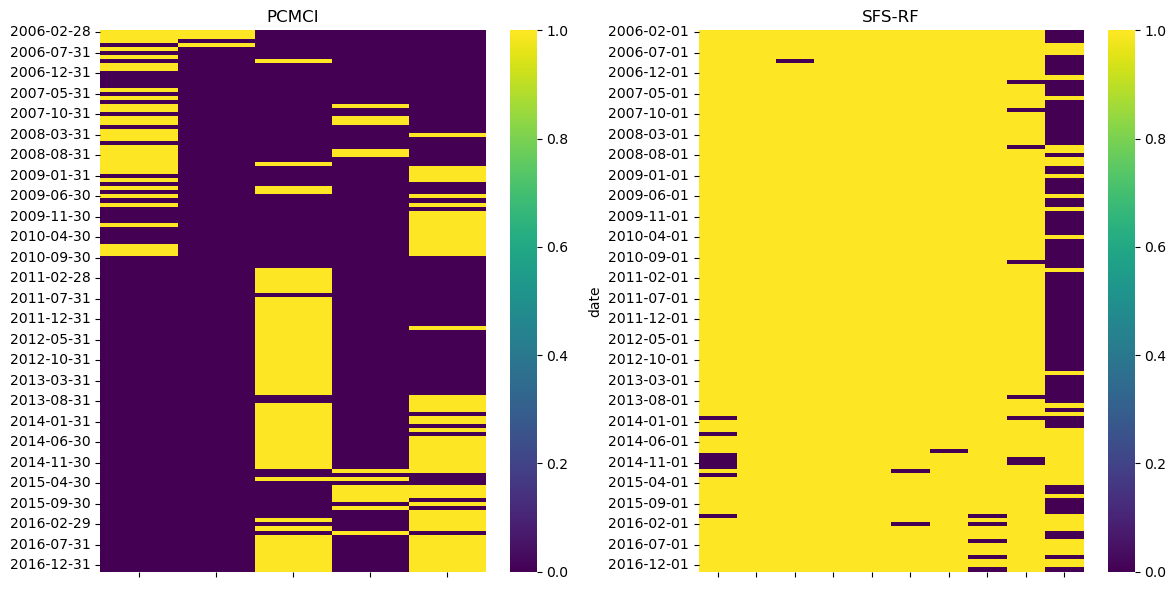

In [70]:
first_fs = "pcmci_nocluster"
second_fs = "sfstscv-rf_nocluster"

# Create a figure with 2 subplots (side by side)
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

check_df = all_parents_df.loc[(all_parents_df['etf'] == etf)&(all_parents_df['fs'] == first_fs)].drop(["etf", "fs"], axis=1)
check_df["date"] = [pd.to_datetime(dtref).strftime('%Y-%m-%d') for dtref in check_df["date"]]
pivot_table_data = check_df.pivot_table(index=["date"], columns=["cluster"], values=["value"]).fillna(0)

# resample
pivot_table_data.index = pd.to_datetime(pivot_table_data.index)
pivot_table_data = pivot_table_data.resample("M").last().fillna(0)

# fix date index
pivot_table_data.index = [pd.to_datetime(dtref).strftime('%Y-%m-%d') for dtref in pivot_table_data.index]

pivot_table_data.columns = pivot_table_data.columns.droplevel()
pivot_table_data.columns = ["" for col in pivot_table_data.columns]

sns.heatmap(pivot_table_data, ax=axs[0], cmap="viridis")
axs[0].set_title(rename_fs[first_fs])

# Plot the second heatmap
check_df = all_parents_df.loc[(all_parents_df['etf'] == etf)&(all_parents_df['fs'] == second_fs)].drop(["etf", "fs"], axis=1)
check_df["date"] = [pd.to_datetime(dtref).strftime('%Y-%m-%d') for dtref in check_df["date"]]
pivot_table_data = check_df.pivot_table(index=["date"], columns=["cluster"], values=["value"]).fillna(0)

pivot_table_data.columns = pivot_table_data.columns.droplevel()
pivot_table_data.columns = ["" for col in pivot_table_data.columns]

sns.heatmap(pivot_table_data, ax=axs[1], cmap="viridis")
axs[1].set_title(rename_fs[second_fs])

# Adjust layout
plt.tight_layout()

# save plot
fig.savefig(os.path.join(results_path, 'compare_clusters_heatmap.png'))

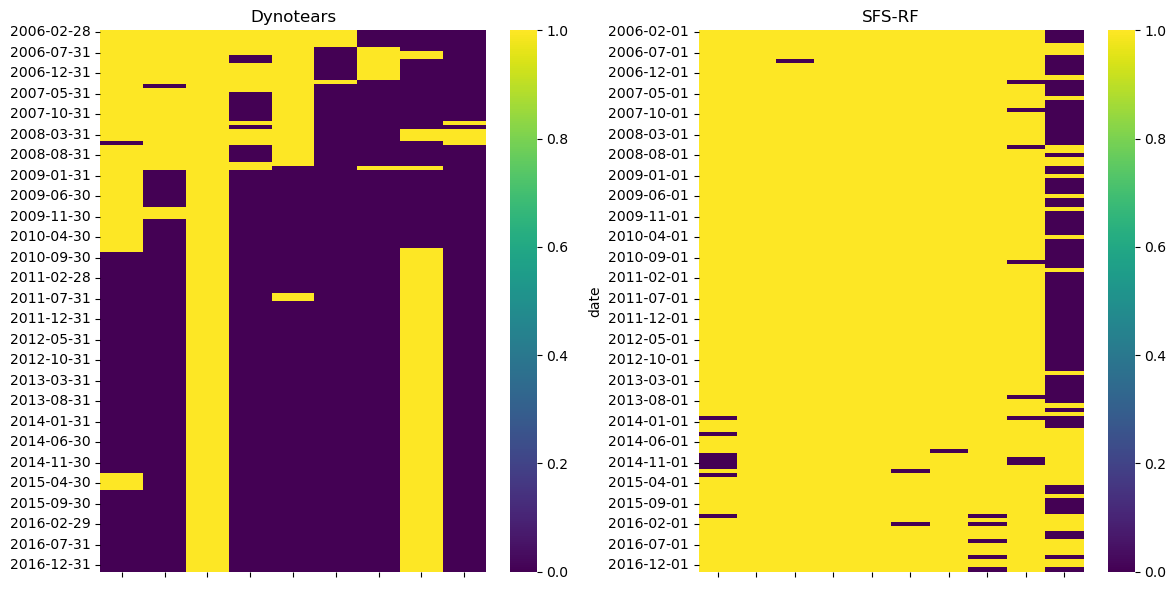

In [72]:
first_fs = "dynotears_nocluster"
second_fs = "sfstscv-rf_nocluster"

# Create a figure with 2 subplots (side by side)
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

check_df = all_parents_df.loc[(all_parents_df['etf'] == etf)&(all_parents_df['fs'] == first_fs)].drop(["etf", "fs"], axis=1)
check_df["date"] = [pd.to_datetime(dtref).strftime('%Y-%m-%d') for dtref in check_df["date"]]
pivot_table_data = check_df.pivot_table(index=["date"], columns=["cluster"], values=["value"]).fillna(0)

# resample
pivot_table_data.index = pd.to_datetime(pivot_table_data.index)
pivot_table_data = pivot_table_data.resample("M").last().fillna(0)

# fix date index
pivot_table_data.index = [pd.to_datetime(dtref).strftime('%Y-%m-%d') for dtref in pivot_table_data.index]

pivot_table_data.columns = pivot_table_data.columns.droplevel()
pivot_table_data.columns = ["" for col in pivot_table_data.columns]

sns.heatmap(pivot_table_data, ax=axs[0], cmap="viridis")
axs[0].set_title(rename_fs[first_fs])

# Plot the second heatmap
check_df = all_parents_df.loc[(all_parents_df['etf'] == etf)&(all_parents_df['fs'] == second_fs)].drop(["etf", "fs"], axis=1)
check_df["date"] = [pd.to_datetime(dtref).strftime('%Y-%m-%d') for dtref in check_df["date"]]
pivot_table_data = check_df.pivot_table(index=["date"], columns=["cluster"], values=["value"]).fillna(0)

pivot_table_data.columns = pivot_table_data.columns.droplevel()
pivot_table_data.columns = ["" for col in pivot_table_data.columns]

sns.heatmap(pivot_table_data, ax=axs[1], cmap="viridis")
axs[1].set_title(rename_fs[second_fs])

# Adjust layout
plt.tight_layout()

# save plot
fig.savefig(os.path.join(results_path, 'compare_clusters_heatmap.png'))

## Selected Features During Specific Periods

In [73]:
event_dates

[('GFC', ('2008-09-01', '2008-11-01')),
 ('Eurozone Debt Crisis', ('2010-05-01', '2012-07-01')),
 ('Swiss Franc Peg Announcement', ('2011-07-01', '2011-09-01')),
 ('Swiss Franc Peg Removal', ('2014-12-01', '2015-02-01')),
 ('COVID-19', ('2020-01-01', '2020-04-01'))]

In [74]:
etf = "ldEXME" # "SPY"
fs = "dynotears_nocluster"

check_df = all_parents_df.loc[(all_parents_df['etf'] == etf)&(all_parents_df['fs'] == fs)].drop(["etf", "fs"], axis=1)

check_df.pivot_table(index=["date"], columns=["fred"], values=["value"]).loc["2008-07-01":"2008-10-01"].dropna(axis=1, how="all").sum(axis=0).sort_values(ascending=False)

       fred   
value  dCMR       4.0
       dCPI       4.0
       ldEXME     4.0
       ldGDPch    4.0
       ldFCIr     1.0
dtype: float64

In [75]:
etf = "ldEXME" # "SPY"
fs = "dynotears_nocluster"

check_df = all_parents_df.loc[(all_parents_df['etf'] == etf)&(all_parents_df['fs'] == fs)].drop(["etf", "fs"], axis=1)

check_df.pivot_table(index=["date"], columns=["fred"], values=["value"]).loc["2008-07-01":"2008-10-01"].dropna(axis=1, how="all").sum(axis=0).sort_values(ascending=False)

       fred   
value  dCMR       4.0
       dCPI       4.0
       ldEXME     4.0
       ldGDPch    4.0
       ldFCIr     1.0
dtype: float64

## Stability Measure

In [79]:
all_etfs_scores = []
all_avg_scores = []
for ticker in all_parents_df["etf"].unique():
    etf_df = all_parents_df[(all_parents_df["etf"] == ticker)]
    etf_df.loc[:, "date"] = [dtref.strftime("%Y-%m-%d") for dtref in etf_df["date"]]

    etf_df = etf_df.sort_values(by=["date"])
    all_scores = []
    for fs in etf_df["fs"].unique():
        fs_etf_df = etf_df[etf_df["fs"] == fs]

        score = []
        for i, date in enumerate(fs_etf_df["date"].unique()):
            if i == 0:
                F_tm1 = set(fs_etf_df.loc[fs_etf_df["date"] == date]["cluster"].dropna().values)
                s = 0
            else:
                F_t = set(fs_etf_df.loc[fs_etf_df["date"] == date]["cluster"].dropna().values)
                s = len(F_tm1.intersection(F_t)) / len(F_tm1.union(F_t)) if len(F_tm1.union(F_t)) != 0 else np.nan
                F_tm1 = copy(F_t)
            score.append({"date": date, "score": s})
        score_df = pd.DataFrame(score)
        score_df["fs"] = fs

        melt_score_df = score_df.melt(["date", "fs"])
        all_scores.append(melt_score_df)
    all_scores_df = pd.concat(all_scores).drop("variable", axis=1)
    all_scores_df["etf"] = ticker
    all_etfs_scores.append(all_scores_df)

    avg_scores = all_scores_df.groupby(["fs"])[["value"]].mean().sort_values(by=["value"], ascending=False).reset_index()
    avg_scores['ticker'] = ticker
    avg_scores = avg_scores[['ticker', 'fs', 'value']]
    all_avg_scores.append(avg_scores)
all_avg_scores_df = pd.concat(all_avg_scores)
all_etfs_scores_df = pd.concat(all_etfs_scores)

In [84]:
all_etfs_scores_df.groupby("fs").mean()[["value"]]

,value
fs,
dynotears_nocluster,0.933586
pairwise-granger_nocluster,0.925505
pcmci_nocluster,0.722714
sfstscv-rf_nocluster,0.932997
var-lingam_nocluster,0.779714


<Axes: xlabel='date'>

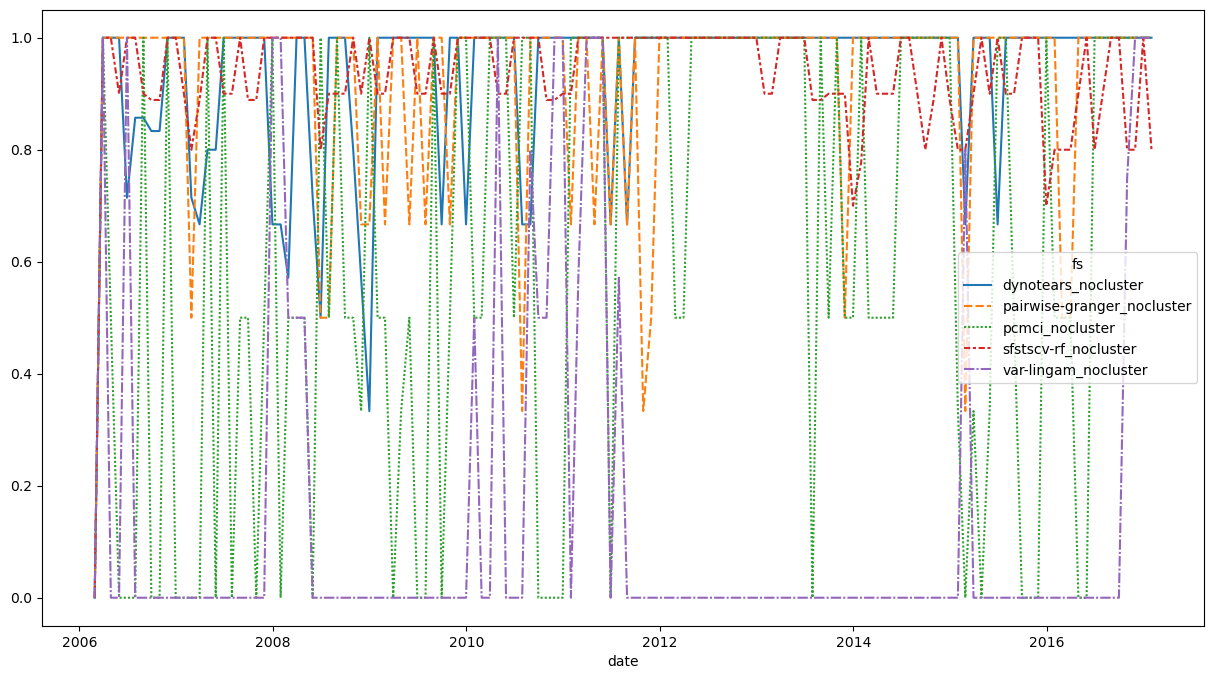

In [82]:
pivot_all_etfs_scores_df = all_etfs_scores_df.pivot_table(index=["date"], columns=["fs"], values=["value"])
pivot_all_etfs_scores_df.columns = pivot_all_etfs_scores_df.columns.droplevel(0)
pivot_all_etfs_scores_df.index = pd.to_datetime(pivot_all_etfs_scores_df.index)
pivot_all_etfs_scores_df = pivot_all_etfs_scores_df.resample("M").last().fillna(0)

plt.figure(figsize=(15, 8))
sns.lineplot(data=pivot_all_etfs_scores_df)